<a href="https://colab.research.google.com/github/hasimoka/BlazeFace-PyTorch/blob/master/ConvertToONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert Pytorch model to ONNX

In [1]:
!git clone https://github.com/hasimoka/BlazeFace-PyTorch.git
%cd BlazeFace-PyTorch/

Cloning into 'BlazeFace-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 24 (delta 2), reused 0 (delta 0), pack-reused 14
Receiving objects: 100% (24/24), 1.89 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/BlazeFace-PyTorch


## PyTorchモデルでの推論

In [3]:
import numpy as np
import torch
import cv2

In [4]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.2.1+cu121
CUDA version: 12.1
cuDNN version: 8906


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Helper code for making plots:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)

    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])

    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none",
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1,
                                        edgecolor="lightskyblue", facecolor="none",
                                        alpha=detections[i, 16])
                ax.add_patch(circle)

    plt.show()

## Load the front and back models

In [7]:
from blazeface import BlazeFace

front_net = BlazeFace().to(device)
front_net.load_weights("blazeface.pth")
front_net.load_anchors("anchors.npy")
back_net = BlazeFace(back_model=True).to(device)
back_net.load_weights("blazefaceback.pth")
back_net.load_anchors("anchorsback.npy")

# Optionally change the thresholds:
front_net.min_score_thresh = 0.75
front_net.min_suppression_threshold = 0.3

## Make a prediction

In [9]:
img = cv2.imread("1face.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [10]:
front_detections = front_net.predict_on_image(img)
front_detections.shape

torch.Size([1, 17])

In [11]:
front_detections

tensor([[0.2714, 0.3171, 0.4416, 0.4873, 0.3863, 0.3127, 0.4613, 0.3186, 0.4400,
         0.3557, 0.4328, 0.3915, 0.3154, 0.3296, 0.4778, 0.3367, 0.9960]])

Found 1 faces


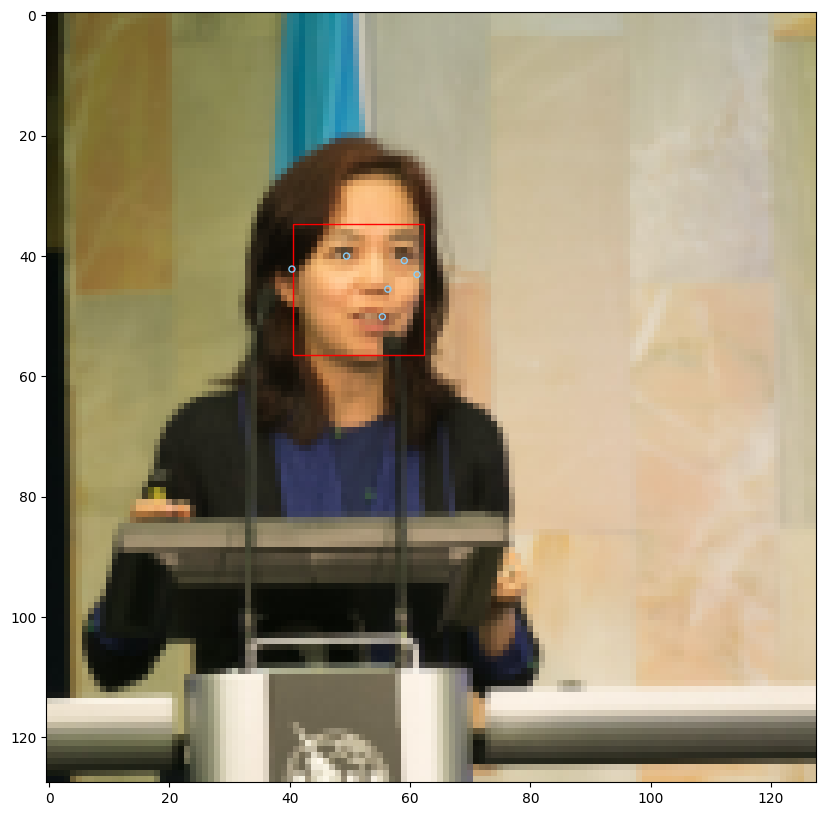

In [12]:
plot_detections(img, front_detections)